# Notebook 02 — Required Classical Machine Learning Models

Goal: train and compare the required classical machine learning models on the Breast Cancer dataset.

We evaluate five required models
- Regression using logistic regression for this classification task
- KNN
- Decision tree
- Random forest
- SVM

We report two types of results
- Cross validation metrics on the training split
- Hold out test metrics on a fixed test split

Key outputs
- Structured comparison tables for cross validation and test
- Confusion matrix for the best model on the test split
- Saved artifacts in outputs and figures



## Setup

Import libraries, load the dataset, and define a fixed train and test split for fair model comparison.
We also create folders used to save tables and plots.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)


from pathlib import Path

ROOT_DIR = Path("..")  # because the notebook is inside notebooks/
FIG_DIR = ROOT_DIR / "figures"
OUT_DIR = ROOT_DIR / "outputs"

FIG_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)

SEED = 42
np.random.seed(SEED)

data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

# Train test split (keep fixed for fairness)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Class counts (train):\n", y_train.value_counts().sort_index())

Train: (455, 30) Test: (114, 30)
Class counts (train):
 target
0    170
1    285
Name: count, dtype: int64


## Model definitions and cross validation

Define the required models and a common evaluation protocol.
We use a pipeline with standardization so that models that depend on scaling are evaluated fairly.



In [2]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Structured scoring (F1 primary)
scoring = {
    "acc": "accuracy",
    "f1": "f1",
    "roc_auc": "roc_auc",
}

models = {
    "LogisticRegression": LogisticRegression(max_iter=5000, random_state=SEED),
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(random_state=SEED),
    "RandomForest": RandomForestClassifier(random_state=SEED),
    "SVM(RBF)": SVC(probability=True, random_state=SEED),  # probability for ROC-AUC
}

## Cross validation results

Compute cross validation metrics on the training split and rank models by mean F1 score.
The resulting table is saved to the outputs folder.



In [3]:
cv_rows = []

for name, model in models.items():
    # Use a common scaler for fair comparison (scaling matters for LR/KNN/SVM)
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model),
    ])

    out = cross_validate(
        pipe, X_train, y_train,
        cv=cv, scoring=scoring,
        return_train_score=False
    )

    cv_rows.append({
        "model": name,
        "cv_acc_mean": np.mean(out["test_acc"]),
        "cv_acc_std": np.std(out["test_acc"]),
        "cv_f1_mean": np.mean(out["test_f1"]),
        "cv_f1_std": np.std(out["test_f1"]),
        "cv_auc_mean": np.mean(out["test_roc_auc"]),
        "cv_auc_std": np.std(out["test_roc_auc"]),
    })

df_cv = pd.DataFrame(cv_rows).sort_values("cv_f1_mean", ascending=False)
display(df_cv)

df_cv.to_csv(OUT_DIR / "02_required_models_cv_results.csv", index=False)
print("Saved:", OUT_DIR / "02_required_models_cv_results.csv")


,model,cv_acc_mean,cv_acc_std,cv_f1_mean,cv_f1_std,cv_auc_mean,cv_auc_std
0,LogisticRegression,0.978022,0.009829,0.982544,0.007752,0.995872,0.004960
4,SVM(RBF),0.969231,0.014579,0.975615,0.011252,0.995562,0.004758
1,KNN,0.962637,0.011207,0.970489,0.009111,0.988235,0.008150
3,RandomForest,0.962637,0.017855,0.969935,0.014605,0.989577,0.008257
2,DecisionTree,0.916484,0.017855,0.931901,0.014435,0.917905,0.020094


Saved: ../outputs/02_required_models_cv_results.csv


## Hold out test evaluation

Fit each pipeline on the training split and evaluate on the fixed test split.
The resulting table is saved to the outputs folder.



In [4]:
# Scale numeric features using training data only.
test_rows = []

for name, model in models.items():
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model),
    ])
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    test_rows.append({
        "model": name,
        "test_acc": accuracy_score(y_test, y_pred),
        "test_f1": f1_score(y_test, y_pred),
        "test_auc": roc_auc_score(y_test, y_proba),
    })

df_test = pd.DataFrame(test_rows).sort_values("test_f1", ascending=False)
display(df_test)

df_test.to_csv(OUT_DIR / "02_required_models_test_results.csv", index=False)
print("Saved:", OUT_DIR / "02_required_models_test_results.csv")


,model,test_acc,test_f1,test_auc
0,LogisticRegression,0.982456,0.986111,0.995370
4,SVM(RBF),0.982456,0.986111,0.995040
1,KNN,0.956140,0.965517,0.978836
3,RandomForest,0.956140,0.965517,0.993882
2,DecisionTree,0.912281,0.928571,0.915675


Saved: ../outputs/02_required_models_test_results.csv


## Best model inspection

Select the best model on the test split by F1 score, then display a confusion matrix for a quick error analysis.
The confusion matrix figure is saved to the figures folder.



Best model on test by F1: LogisticRegression

Classification report:

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



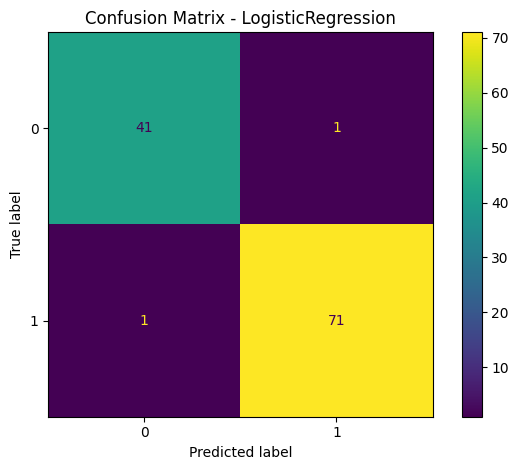

Saved: ../figures/02_confusion_matrix_best.png


In [5]:
# Scale numeric features using training data only.
best_model_name = df_test.iloc[0]["model"]
print("Best model on test by F1:", best_model_name)

best_model = models[best_model_name]
best_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", best_model),
])
best_pipe.fit(X_train, y_train)

y_pred = best_pipe.predict(X_test)
print("\nClassification report:\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title(f"Confusion Matrix - {best_model_name}")
plt.tight_layout()
plt.savefig(FIG_DIR / "02_confusion_matrix_best.png", dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", FIG_DIR / "02_confusion_matrix_best.png")